In [155]:
import pandas as pd
from datetime import timedelta
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
from scipy import stats 
import requests 
from urllib.parse import urlencode
import warnings
warnings.filterwarnings('ignore')
import numpy as np

##  Задание 1

#### Retention – один из самых важных показателей в компании. Ваша задача – написать функцию, которая будет считать retention игроков (по дням от даты регистрации игрока).

In [156]:
reg = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-maksim-gritsaj-khh-248a6/shared/problem1-reg_data.csv',sep = ';')
auth = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-maksim-gritsaj-khh-248a6/shared/problem1-auth_data.csv', sep = ';')

Посмотрим, как устроены данные

In [157]:
reg.head()

,reg_ts,uid
0,911382223,1
1,932683089,2
2,947802447,3
3,959523541,4
4,969103313,5


In [158]:
auth.head()

,auth_ts,uid
0,911382223,1
1,932683089,2
2,932921206,2
3,933393015,2
4,933875379,2


Становится понятным, что соединить таблички можно по UID, а время представлено в формате epoch  

In [159]:
pd.to_datetime(reg['reg_ts'], unit='s').min()

Timestamp('1998-11-18 09:43:43')

В условии нет подробностей о формате таблички, поэтому я решил сделать два варианта <p>
(А также добавил выбор свежести данных, так как вряд ли кого то интересуют данные за 1998 год)

Вариант №1 - Рассчет среднего retention для n дней (задается пользователем) с n-ной свежестью данных (задается пользователем)

In [160]:
def mean_retention(auth_df, reg_df, reg_col, auth_col, id_col, from_when, retention_period):
    
    reg_df[reg_col] = pd.to_datetime(reg_df[reg_col], unit='s') 
    auth_df[auth_col] = pd.to_datetime(auth_df[auth_col], unit='s')
    united_df = auth_df.merge(reg_df, on=id_col, how='left') 
    
    # Берем данные только за нужный срок и убираем юзеров, у которых еще нет желаемого периода с регистрации
    united_df =  united_df[(united_df[reg_col].max() - timedelta(days = retention_period)) > united_df[reg_col]]  
    united_df =  united_df[united_df[reg_col] >= pd.to_datetime(from_when)] 
    
    united_df['days'] = (united_df[auth_col] - united_df[reg_col]).dt.days # Дни с момента регистрации
    
    rt_table = (united_df.groupby('days')[id_col]
               .nunique()
               .reset_index()
               .rename(columns={id_col: 'retention'}))
    
    rt_table['retention'] = rt_table['retention'] / united_df[id_col].nunique() # Считаем retention
    rt_table = rt_table.iloc[:retention_period].set_index('days') # Ограничиваем период расчета 
    rt_table = rt_table.style.format("{:.2%}") # И форматируем в проценты
    
    return rt_table


In [161]:
mean_retention(auth_df = auth, reg_df = reg, reg_col = 'reg_ts', auth_col = 'auth_ts',\
               id_col = 'uid', from_when = '2017-10-05', retention_period = 31)

,retention
days,
0,100.00%
1,4.03%
2,4.33%
3,4.94%
4,5.66%
5,6.42%
6,7.36%
7,4.41%
8,5.04%


Вариант №2 - Рассчет retention по когортам (свежесть когорт задается пользователем)

In [162]:
def cohort_retention(auth_df, reg_df, reg_col, auth_col, id_col, from_when):
    
    reg_df[reg_col] = pd.to_datetime(reg_df[reg_col], unit='s') 
    auth_df[auth_col] = pd.to_datetime(auth_df[auth_col], unit='s')
    united_df = auth_df.merge(reg_df, on=id_col, how='left') 
    
    # Берем данные только за нужный срок                               
    
    united_df =  united_df[united_df[reg_col] >= pd.to_datetime(from_when)] 
    
    united_df['days'] = (united_df[auth_col] - united_df[reg_col]).dt.days # Дни с момента регистрации
    united_df[reg_col] = pd.to_datetime(united_df[reg_col]).dt.to_period("d") # Делим юзеров на когорты
    
    
    rt_table = united_df.pivot_table(index = reg_col, columns='days', values = id_col, aggfunc = 'nunique')
    rt_table = rt_table.div(rt_table.iloc[:,0], axis = 0) # Делаем сводную таблицу и рассчитываем retention 
    
    rt_table = rt_table.style.format("{:.2%}",  na_rep= '') # И форматируем в проценты, а также убираем пропуски
    
    return rt_table

In [163]:
cohort_retention(auth_df = auth, reg_df = reg, reg_col = 'reg_ts', auth_col = 'auth_ts',\
               id_col = 'uid', from_when = '2020-09-10')

days,0,1,2,3,4,5,6,7,8,9,10,11,12,13
reg_ts,,,,,,,,,,,,,,
2020-09-10,100.00%,4.29%,3.98%,4.85%,5.84%,6.65%,7.09%,5.28%,4.41%,5.34%,5.28%,5.22%,4.85%,0.99%
2020-09-11,100.00%,3.04%,4.34%,5.52%,5.58%,5.27%,8.50%,4.22%,4.28%,5.02%,5.71%,4.34%,1.49%,
2020-09-12,100.00%,3.53%,4.89%,4.21%,5.64%,5.95%,7.37%,4.21%,5.51%,5.45%,4.71%,0.68%,,
2020-09-13,100.00%,4.02%,3.96%,4.64%,6.12%,6.37%,6.00%,5.07%,4.20%,5.07%,1.24%,,,
2020-09-14,100.00%,4.39%,3.95%,4.45%,6.24%,6.49%,7.66%,5.00%,3.77%,1.05%,,,,
2020-09-15,100.00%,4.68%,3.70%,5.79%,5.18%,5.98%,7.76%,3.82%,0.62%,,,,,
2020-09-16,100.00%,4.12%,3.75%,4.68%,6.34%,7.08%,5.91%,0.68%,,,,,,
2020-09-17,100.00%,3.81%,4.12%,5.16%,5.90%,5.77%,1.72%,,,,,,,
2020-09-18,100.00%,4.23%,3.87%,5.58%,4.72%,1.23%,,,,,,,,


## Задание 2
#### Имеются результаты A/B теста, в котором двум группам пользователей предлагались различные наборы акционных предложений. Известно, что ARPU в тестовой группе выше на 5%, чем в контрольной. При этом в контрольной группе 1928 игроков из 202103 оказались платящими, а в тестовой – 1805 из 202667.

#### Какой набор предложений можно считать лучшим? Какие метрики стоит проанализировать для принятия правильного решения и как?

In [164]:
api_url      = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?' 
key_research = 'https://disk.yandex.ru/d/SOkIsD5A8xlI7Q' 

url_research = api_url + urlencode(dict(public_key=key_research)) 

resp_research = requests.get(url_research) 

download_research = resp_research.json()['href']

research = pd.read_csv(download_research, sep = ';')

In [165]:
research.head()

,user_id,revenue,testgroup
0,1,0,b
1,2,0,a
2,3,0,a
3,4,0,b
4,5,0,b


Проверим данные из условий

In [166]:
research.query('revenue > 0 and testgroup == "b"').count()

user_id      1805
revenue      1805
testgroup    1805
dtype: int64

In [167]:
research.query('revenue > 0 and testgroup == "a"').count()

user_id      1928
revenue      1928
testgroup    1928
dtype: int64

In [168]:
research.query('testgroup == "a"').count()

user_id      202103
revenue      202103
testgroup    202103
dtype: int64

In [169]:
research.query('testgroup == "b"').count()

user_id      202667
revenue      202667
testgroup    202667
dtype: int64

Условия задачи не солгали. Плюс размеры выборок примерно равны, что тоже хорошо


Итак, для начала стоит обратить внимание на уже названную в задании метрику - 
#### Average Revenue Per User <p>
Но так как мы имеем дело с разными по размеру выборками, а также разной долей платящих, предлагаю проанализировать именно Average Revenue Per Paying User  
 <p>   (про конверсию в платящего поговорим отдельно)

In [170]:
group_b = research.query('revenue > 0 and testgroup == "b"').revenue
group_b.describe()

count    1805.000000
mean     3003.658172
std       572.619709
min      2000.000000
25%      2513.000000
50%      3022.000000
75%      3478.000000
max      4000.000000
Name: revenue, dtype: float64

In [171]:
group_a = research.query('revenue > 0 and testgroup == "a"').revenue
group_a.describe()

count     1928.000000
mean      2663.998444
std       9049.039763
min        200.000000
25%        257.000000
50%        311.000000
75%        361.000000
max      37433.000000
Name: revenue, dtype: float64

Чисто по цифрам группа B не вызывает больших вопросов, а вот группа А вынуждает провести тест на аутлаеры 

In [172]:
# Воспользуемся методом стандартного отклонения

def detect_outliers_zscore(data, threshold=3):
    z_scores = stats.zscore(data)
    return np.abs(z_scores) > threshold

print("Аутлаеры в группе В:", group_b[detect_outliers_zscore(group_b)])
print("Аутлаеры в группе А:", group_a[detect_outliers_zscore(group_a)])

Аутлаеры в группе В: Series([], Name: revenue, dtype: int64)
Аутлаеры в группе А: 416       37324
4428      37304
5777      37315
8065      37307
8743      37334
          ...  
360696    37347
378668    37297
389341    37298
394580    37302
399294    37321
Name: revenue, Length: 123, dtype: int64


Ага, что и требовалось доказать. В группе А имеется 123 выброса, которые определенно стоит исключить из анализа, чтобы статистика показала более честные показатели <p> 
    (к этим выбросам мы еще вернемся)

In [173]:
group_a_w = research.query('0 < revenue < 37000 and testgroup == "a"').revenue

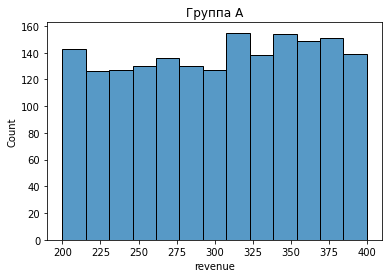

In [174]:
plt.title('Группа А')
sns.histplot(group_a_w)
plt.show()


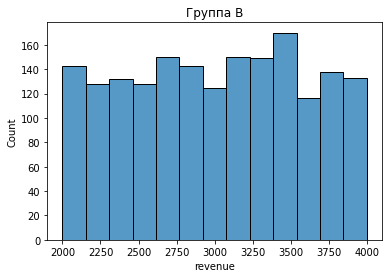

In [175]:
plt.title('Группа B')
sns.histplot(group_b)
plt.show()

К сожалению, нормальностью распределения тут и не пахнет, но едва ли это можно поменять (из значений видно, что логарифмирование не сильно изменит картину) <p>
    Но унывать не стоит - проведению t-теста это не помешает так сильно, как аутлаеры <p>
     
        Спойлер: уже на этом этапе становится очевидным, что группа B имеет ARPPU значительно выше и даже без 
        теста очевидно, что это различие статистически значимо 
    
    

In [176]:
stats.ttest_ind(group_a_w, group_b)

Ttest_indResult(statistic=-199.39722533995328, pvalue=0.0)

P-value < 0.05, а значит отклоняем нулевую гипотезу об отсутствии стат. значимых различий <p>
Значение отрицательное, а значит группа B у нас предлагает среднее значение ARPPU выше

А теперь давайте вернемся к выбросам и посмотрим на них подробнее

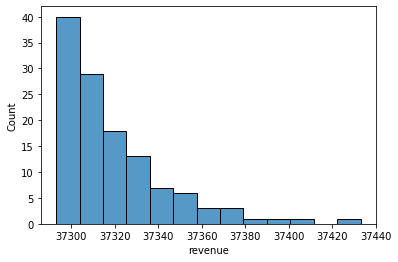

In [177]:
sns.histplot(research.query('revenue > 37000 and testgroup == "a"').revenue)
plt.show()

Сначала у меня была гипотеза, что просто в группу A мог попасть кит, который один совершил такие дорогие покупки, но я уже успел проверить количество уникальных пользователей - это все разные люди

In [178]:
research.user_id.nunique() / research.user_id.count()

1.0

Поэтому мое второе предположение, что в наборе акционных предложений группы A есть конкретное предложение (или группа предложений), которые побуждают совершать такую дорогую покупку. Но как мне кажется, это одно конкретное предложение на около 37300 рублей, поскольку именно к этой сумме тяготеют данные, а правая ассиметрия говорит, что меньше никто из них не заплатил, а динамика вправо скорее всего результат еще пары небольших покупок некоторых пользователей (или комиссии, но это не суть важно) <p>
    Проще говоря, эти 123 наблюдения надо анализировать отдельно

Теперь перейдем к конверсии в платящего пользователя 
#### Conversion Rate

In [179]:
conv_a = round(group_a.count() / research.query('testgroup == "a"').user_id.count() * 100, 2)
conv_b = round(group_b.count() / research.query('testgroup == "b"').user_id.count() * 100, 2)
print(f"Конверсия в группе А: {conv_a}%")
print(f"Конверсия в группе B: {conv_b}%")

Конверсия в группе А: 0.95%
Конверсия в группе B: 0.89%


В группе А значение конверсии немного больше, но стоит проверить это на стат. значимость 

Давайте добавим столбик с dummy variables в датасет, чтобы провести тест 

In [180]:
dummy = []
for i in research.revenue:
    if i == 0:
        dummy.append('0')
    else:
        dummy.append('1')
research['dummy'] = dummy

research.head()

,user_id,revenue,testgroup,dummy
0,1,0,b,0
1,2,0,a,0
2,3,0,a,0
3,4,0,b,0
4,5,0,b,0


Так как эта переменная категориальная, то нам подойдет критерий хи-квадрат. Соберем для него таблицу сопряженности и проведем тест

In [181]:
chi = pd.crosstab(research['testgroup'], research['dummy'])
print(f"p_value: {stats.chi2_contingency(chi)[1]}")

p_value: 0.03647561892312613


P-value у нас меньше 0.05, а значит отклоняем нулевую гипотезу об отсутствии стат. значимых различий в CR 

И по быстрому перед выводом давайте посмотрим, что будет, если исключить выбросы

In [182]:
research_w = research.query('revenue < 37000')
chi_w = pd.crosstab(research_w['testgroup'], research_w['dummy'])
print(f"p_value: {stats.chi2_contingency(chi_w)[1]}")

p_value: 0.9316668591658103


Стат. значимой разницы - нет

### Вывод

Как мир не делится на черное и белое, так и по результатам этого теста нельзя сказать, что нужно выбрать один из наборов, а про другой забыть. Давайте коротко вспомним основные выводы: 

- **ARPPU** больше у группы B (где то в 10 раз)
- **Conversion Rate** больше у группы А 

НО! Группа А содержит много выбросов, которые корректно рассматривать отдельно, поэтому если исключить их из анализа, то получим: 
- **CR** у групп статистически не отличаются 

На мой взгляд, стоит определенно вводить набор из тестовой группы B, но в тоже время проанализировать 123 наблюдения из контрольной группы А, чтобы определить, какое именно предложение способствовало большой покупке. Определив это предложение, надо интегрировать его в набор тестовой группы В



## Задание 3
#### В игре Plants & Gardens каждый месяц проводятся тематические события, ограниченные по времени. В них игроки могут получить уникальные предметы для сада и персонажей, дополнительные монеты или бонусы. Для получения награды требуется пройти ряд уровней за определенное время. С помощью каких метрик можно оценить результаты последнего прошедшего события?

#### Предположим, в другом событии мы усложнили механику событий так, что при каждой неудачной попытке выполнения уровня игрок будет откатываться на несколько уровней назад. Изменится ли набор метрик оценки результата? Если да, то как?

Метрики для оценки последнего прошедшего события:

- **DAU (Daily Active Users)** и **Retention** - обе метрики по сути показывают то, с какой активностью люди заходят в игру ежедневно. DAU даст абсолютные значения, а retention - относительные. Если показатели сохраняются высокими в течение долгого периода, то можно сказать, что событие отлично удерживает аудиторию 
- **Conversion Rate** - тут стоит, конечно, определиться с тем, какое действие мы будем отслеживать. Например, можно анализировать конверсию в покупку (акция ограничена по времени, а значит люди могут теоретически торопиться получить уникальные предметы), или конверсию в получение награды, чтобы оценить, насколько сложно игрокам добиться успеха
- **ARPU (Average Revenue Per User)** - раз мы позволяем игрокам бесплатно получать монеты и бонусы, то стоит рассмотреть, не в ущерб ли это доходу компании 
- **Average Session Count** - поможет узнать, увеличивается ли количество заходов пользователей в игру 
- **Average Session Length** - а тут можно узнать, увеличивается ли длительность сессий пользователей 

Метрики для усложненной механики:

- **Среднее число откатов** - покажет, насколько часто пользователи сталкиваются с неудачей 
- **Churn Rate после отката (внутри одной сессии)** - нужно понимать, насколько критически сказывается откат на желании пользователя играть дальше
- **Среднее время между сессиями** - перепрохождение одних и тех же испытаний может наскучивать, из за чего пользователи могут оттягивать момент повторной попытки

Метрики, предложенные до этого, останутся все актуальны, но очевидно, что ценность их информации будет выше при сравнении показателей с и без новой механики